In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict

import os
import sys
from tqdm import tqdm
from glob import glob

from sklearnex import patch_sklearn
patch_sklearn()

import sklearn

import sklearn.pipeline 
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model

from sklearn.preprocessing import StandardScaler
from multiprocessing import Pool

import optuna

sys.path.append("/home/icb/sergey.vilov/workspace/MLM/mpra/utils/") 

from models import *
from misc import dotdict

import scipy.stats
import pickle

import gensim.models 

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 20})

model_colors = {'Species-aware':"#E69F00",'Species-agnostic':"#56B4E9",
                'DNABERT-2':"#CC79A7", 'NT-MS-v2-500M':"#009E73", "k-mers":"#0072B2",
               'Saluki human':"#F0E442",'BC3MS(k-mers)':"#0072B2", 'BC3MS(emb)':"#D55E00"}

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/home/icb/sergey.vilov/miniconda3/envs/mlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/MLM/agarwal_2022/'

In [3]:
folds_df = pd.read_csv(data_dir + 'data/saluki_paper/Fig3_S4/binnedgenes.txt', sep='\t', usecols=[0,1],
                      names=['Fold','gene_id'], skiprows=1).set_index('gene_id') #folds as they are in Agarwal article

folds_df = folds_df-1 #to 0-based

In [4]:
#features_df = pd.read_csv(data_dir + 'data/human/seqFeatWithKmerFreqs.txt.gz', sep='\t', 
#                                      usecols=lambda x: not 'ORF.' in x and not '5UTR.' in x).set_index('GENE') #basic features. 3'UTR and 5'UTR k-mers, ORF, target

features_df = pd.read_parquet(data_dir + 'data/human/seqFeatWithKmerFreqs_no5UTR.parquet').set_index('GENE')

target_df = features_df[['HALFLIFE']]
features_df = features_df.drop(columns='HALFLIFE')

In [5]:
transcript_to_gene = pd.read_csv(data_dir + '../UTR_coords/GRCh38_EnsembleCanonical_HGNC.tsv.gz', sep='\t', 
                                     names=['gene_id','transcript_id'], skiprows=1,usecols=[0,1]).set_index('transcript_id')

In [6]:
#get FASTA seqs

human_fasta = data_dir + '../fasta/240_species/species/Homo_sapiens.fa'

utr_df = defaultdict(str)

with open(human_fasta, 'r') as f:
    for line in f:
        if line.startswith('>'):
            transcript_id = line[1:].split(':')[0].split('.')[0]
        else:
            utr_df[transcript_id] += line.rstrip().upper()

In [7]:
utr_df = pd.DataFrame(utr_df.values(),
             index=transcript_to_gene.loc[utr_df.keys()].gene_id, 
             columns=['seq'])

In [8]:
input_params = dotdict({})

input_params.model_name = '3K' #embedding name, can be "Species-aware",""Species-agnostic", "MLM" "word2vec" "griesemer" or "Nmers" where N is an integer

input_params.output_dir = './test' #output folder

input_params.N_trials = 300 #number of optuna trials
input_params.keep_first = True #perform hpp search only at the first split, then use these hyperparameters

input_params.N_splits = 100 #number of GroupShuffleSplits
input_params.N_CVsplits = 5 #number of CV splits for hyperparameter search
input_params.seed = 1 #seed fot GroupShuffleSplit

In [9]:
base_features = input_params.model_name.split('-')[-1]
base_features

'3K'

In [10]:
data_df = [folds_df,target_df]

if 'B' in base_features:
    
    print('adding basic features')
    data_df.append(features_df.iloc[:,:8])

if 'C' in base_features:

    print('adding codons')
    data_df.append(features_df[[x for x in features_df.columns if x.startswith('Codon.')]])

if '3K' in base_features:

    print("adding k-mer embeddings for 3'UTRs")
    data_df.append(features_df[[x for x in features_df.columns if x.startswith('3UTR.')]])

if 'S' in base_features:

    print('adding SeqWeaver RBP binding (780)')
    for region in ('3pUTR','5pUTR','ORF'):
        df = pd.read_csv(data_dir + f'data/human/SeqWeaver_predictions/{region}_avg.txt.gz', sep='\t').set_index('Group.1')
        data_df.append(df)

if 'M' in base_features:
    print('miRNA target repression (319)')
    df = pd.read_csv(data_dir + 'data/human/CWCS.txt.gz', sep='\t').set_index('GeneID')
    data_df.append(df)

adding k-mer embeddings for 3'UTRs


In [11]:
data_df = pd.concat(data_df,axis=1) #concat all features, except embeddings

In [12]:
data_df = data_df[~data_df.HALFLIFE.isna()]
data_df.fillna(0, inplace=True)

In [13]:
#get MLM embeddings

mlm_embeddings = []

if  input_params.model_name.startswith('Species-'):
    embeddings_dir = f'{data_dir}../3UTR_embeddings/{"-".join(input_params.model_name.split("-")[:-1])}'
    print(f'Loading model embeddings from {embeddings_dir}/embeddings.npy')
    mlm_embeddings = np.load(f'{embeddings_dir}/embeddings.npy')
    utr_names = pd.read_csv( f'{embeddings_dir}/Homo_sapiens.fa.fai', 
                            usecols=[0], sep='\t',names=['seq_name']).seq_name.apply(lambda x:x.split(':')[0].split('.')[0]).values 

elif  input_params.model_name.startswith('NT-') or  input_params.model_name.startswith('DNABERT-2'):
    embeddings_dir = f'{data_dir}../3UTR_embeddings/{"-".join(input_params.model_name.split("-")[:-1])}'
    print(f'Loading model embeddings from {embeddings_dir}')
    mlm_embeddings, utr_names = [], []
    for emb_file in tqdm(glob(f'{embeddings_dir}/ENST*.pickle')):
        with open(emb_file, 'rb') as f:
            data = pickle.load(f)
            utr_names_batch, embeddings_batch = data[0],data[1]
            mlm_embeddings.extend(embeddings_batch)
            utr_names.extend(utr_names_batch)
    mlm_embeddings = np.vstack(mlm_embeddings)
    utr_names = [x.split('.')[0] for x in utr_names]

print('done')

done


In [14]:
#get sequence embedding depending on the model

if len(mlm_embeddings)>0:            

    #MLM embeddings are made for transcripts
    #get corresponding gene names

    embedding_transcripts = [x.split('.')[0] for x in utr_names]

    embeddings_df = pd.DataFrame(mlm_embeddings, 
                                     index=transcript_to_gene.loc[embedding_transcripts].gene_id, 
                                     columns=[f'emb_{x}' for x in range(mlm_embeddings.shape[1])])

elif 'mers' in input_params.model_name:
    
    k = int(input_params.model_name[0])
        
    kmerizer = Kmerizer(k=k)
    
    Nmer_embeddings = utr_df.seq.apply(lambda x: kmerizer.kmerize(x))
    
    embeddings_df = pd.DataFrame(Nmer_embeddings.tolist(), index=Nmer_embeddings.index, columns=[f'emb_{x}' for x in range(4**k)])

elif input_params.model_name=='word2vec':
        
    kmerizer_w2v = Kmerizer(k=4)

    w2v_model = gensim.models.Word2Vec(sentences=utr_df.seq.apply(lambda x: kmerizer_w2v.tokenize(x)), 
                             vector_size=128, window=5, min_count=1, workers=4, sg=1) #default: CBOW

    word2vec_emb = utr_df.seq.apply(
        lambda x: np.mean([w2v_model.wv[x]  for x in kmerizer_w2v.tokenize(x)],axis=0)) #average embedding of all 4-mers in the sequence

    word2vec_emb = word2vec_emb[~word2vec_emb.isna()]
    
    embeddings_df = pd.DataFrame(word2vec_emb.tolist(), index=word2vec_emb.index, columns=[f'emb_{x}' for x in range(128)])

In [15]:
if len(mlm_embeddings)>0:            

    data_df = pd.concat([data_df,embeddings_df], join='inner', axis=1)

#data_df.reset_index(drop=True, inplace=True)

In [16]:
X = data_df.drop(columns=['Fold','HALFLIFE']).values#all columns except HALFLIFE and fold

y = data_df['HALFLIFE'].values

genes = data_df.index.values

folds = data_df['Fold'].values

N_folds = int(max(folds))+1

In [17]:
del data_df

In [18]:
def apply_SVR(args):
        
    test_hpp, (train_idx, test_idx) = args 

    pipe = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(),
                                                  sklearn.svm.SVR(**test_hpp))
    pipe.fit(X[val_idx][train_idx],y[val_idx][train_idx])

    R2_score = pipe.score(X[val_idx][test_idx],y[val_idx][test_idx])
        
    return R2_score


def hpp_search(val_idx, cv_splits = 10):
    
    '''
    Perform Hyperparameter Search using OPTUNA Bayesian Optimisation strategy
    
    The bets hyperparameters should maximize coefficient of determination (R2)
    
    The hyperparameter range should first be adjused with grid search to make the BO algorithm converge in reasonable time
    '''


    def objective(trial):

        C = trial.suggest_float("C", 1e-2, 1e2, log=True)
        epsilon = trial.suggest_float("epsilon", 1e-5, 1, log=True)
        gamma = trial.suggest_float("gamma", 1e-5, 1, log=True)
        
        test_hpp = {'C':C, 'epsilon':epsilon, 'gamma':gamma}
        
        pool = Pool(processes=input_params.n_jobs,maxtasksperchild=3)

        cv_scores = []
        
        kfold = sklearn.model_selection.KFold(n_splits=cv_splits)
        
        params = zip((test_hpp for fold_idx in range(cv_splits)), kfold.split(X[val_idx], y[val_idx]))
        
        for res in pool.imap(apply_SVR,params):
            cv_scores.append(res)
     
        pool.close()
        pool.join()
    
        return np.mean(cv_scores)
    
    study = optuna.create_study(direction = "maximize")

    study.optimize(objective, n_trials = input_params.N_trials)
    
    best_params = study.best_params
    
    return best_params

In [ ]:
cv_scores = [] #scores and best hyperparameters for each split
res_df = []

best_hpp_models = {'Species-aware-BC3MS':{'C': 17.2, 'epsilon': 0.73, 'gamma': 2e-4},
            'Species-agnostic-BC3MS':{'C': 15.3, 'epsilon': 0.37, 'gamma': 1.8e-4},
            'NT-MS-v2-500M-BC3MS':{'C': 100, 'epsilon': 0.84, 'gamma': 1.3e-5},
            'DNABERT-2-BC3MS':{'C': 19, 'epsilon': 9.8e-5, 'gamma': 1.4e-4},
            'DNABERT-2-B3': {'C': 100, 'epsilon': 2e-3, 'gamma': 6.6e-05},
            'BCMS': {'C': 18.5, 'epsilon': 2.8e-2, 'gamma': 1.3e-4},
            'Species-agnostic-B3':{'C': 86, 'epsilon': 0.06, 'gamma': 2.4e-4},
            'Species-agnostic-3':{'C': 22, 'epsilon': 0.003, 'gamma': 5.6e-4},
            'Species-aware-3':{'C': 2.05, 'epsilon': 0.091, 'gamma': 0.0037},
            '3K': {'C': 8.7, 'epsilon': 1.8e-3, 'gamma': 4.2e-05},
            'DNABERT-2-3': {'C': 0.69, 'epsilon': 2.6e-4, 'gamma': 6.3e-4},
            'NT-MS-v2-500M-3':{'C': 21, 'epsilon': 0.75, 'gamma': 3.8e-05},
           }

for fold in range(N_folds):
    
        print(f'Fold {fold}')
        
        X_train, X_test, y_train, y_test = X[folds!=fold],X[folds==fold],y[folds!=fold],y[folds==fold]

        if input_params.model_name not in best_hpp_models.keys() and (fold==0 or input_params.keep_first==False):
            #perform only ones if input_params.keep_first==True
            val_idx = np.where(folds==0)[0]
            best_hpp = hpp_search(val_idx,cv_splits = input_params.N_CVsplits)
        elif input_params.model_name  in best_hpp_models.keys():
            best_hpp = best_hpp_models[input_params.model_name]
            
        pipe = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(),
                                              sklearn.svm.SVR(**best_hpp))
        
        pipe.fit(X_train,y_train)
                    
        y_pred = pipe.predict(X_test) 
                
        #pipe_lasso = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.linear_model.LassoCV(cv=input_params.N_CVsplits, alphas=10.**np.arange(-6,0))) 
        #pipe_lasso.fit(X_train,y_train)
        #y_pred_lasso = pipe_lasso.predict(X_test)

        pipe_ridge = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.linear_model.RidgeCV(cv=input_params.N_CVsplits, alphas=10.**np.arange(-5,5))) 
        pipe_ridge.fit(X_train,y_train)
        y_pred_ridge = pipe_ridge.predict(X_test)
        
        fold_res = np.vstack([np.ones((len(y_test),))*fold,genes[folds==fold],y_test,y_pred_ridge,y_pred]).T

        res_df.append(fold_res)
        #cv_scores.append({'fold':fold,
        #                 'r2_svr':sklearn.metrics.r2_score(y_test,y_pred),
        #                'pearson_r_svr':scipy.stats.pearsonr(y_test,y_pred)[0],
        #                 'r2_ridge':sklearn.metrics.r2_score(y_test,y_pred_ridge),
        #                 'pearson_r_ridge':scipy.stats.pearsonr(y_test,y_pred_ridge)[0]
        #                 }|best_hpp)

    
#cv_scores = pd.DataFrame(cv_scores)
res_df = np.vstack(res_df)
res_df = pd.DataFrame(res_df,columns=['fold','gene','y_true','y_pred_ridge','y_pred_svr'])

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


In [ ]:
#cv_scores.to_csv(data_dir + f'predictions/{input_params.model_name}.tsv', sep = '\t', index=None)
res_df.to_csv(data_dir + f'predictions/{input_params.model_name}-full.tsv', sep = '\t', index=None)

# Analyse results

In [3]:
import scipy.stats 

def compute_score_folds(x):
    df = len(x)-1 #number of folds minus 1
    ci_95 = scipy.stats.t.interval(0.95, df, loc=np.mean(x), scale=np.std(x))
    return pd.Series({'Pearson_r':np.mean(x), 'CI_95':np.diff(ci_95)[0]/2})

def compute_score(y_true,y_pred):
    pearson_r = scipy.stats.pearsonr(y_true,y_pred)
    ci_95 = pearson_r.confidence_interval()
    ci_95 = np.diff(ci_95)[0]/2
    pearson_r = pearson_r[0]
    return pd.Series({'Pearson_r':pearson_r, 'CI_95':ci_95})

In [4]:
!ls {data_dir}/predictions

3K-full.tsv		  Species-agnostic-3-full.tsv
BCMS.tsv		  Species-agnostic-3.tsv
DNABERT-2-3-full.tsv	  Species-agnostic-B3.tsv
DNABERT-2-3.tsv		  Species-agnostic-BC3MS-full.tsv
DNABERT-2-B3.tsv	  Species-agnostic-BC3MS.tsv
DNABERT-2-BC3MS.tsv	  Species-aware-3-full.tsv
NT-MS-v2-500M-3-full.tsv  Species-aware-3.tsv
NT-MS-v2-500M-3.tsv	  Species-aware-BC3MS.tsv
NT-MS-v2-500M-BC3MS.tsv


In [4]:
regressor = 'ridge' #'ridge' or 'svr'

In [8]:
data_dir + f'predictions/{model_name}-full.tsv'

'/lustre/groups/epigenereg01/workspace/projects/vale/MLM/agarwal_2022/predictions/3K-full.tsv'

In [5]:
paper_results = pd.read_csv(data_dir + 'data/saluki_paper/Fig5_S6/experimentResults.csv')[['Saluki human','BC3MS']]
#paper_results2 = pd.read_csv(data_dir + 'data/saluki_paper/Fig3_S4/experimentResults.csv')[['B3']]

paper_scores = paper_results.apply(compute_score_folds)

res_df = [paper_scores]

for model_name in ('Species-agnostic-BC3MS','Species-agnostic-3','Species-aware-3','DNABERT-2-3','NT-MS-v2-500M-3','3K'):
#for model_name in ('Species-agnostic-3','Species-aware-3','Species-agnostic-BC3MS'):
#for model_name in ('Species-agnostic-BC3MS','Species-aware-BC3MS','DNABERT-2-BC3MS','NT-MS-v2-500M-BC3MS'):
#for model_name in ('Species-agnostic-B3','DNABERT-2-B3','NT-MS-v2-500M-BC3MS','BCMS'):
    model_results = pd.read_csv(data_dir + f'predictions/{model_name}-full.tsv', sep = '\t')
    scores = compute_score(model_results.y_true, model_results[f'y_pred_{regressor}'])
    scores.name = model_name.replace('-3','')
    #model_results = model_results.rename(columns={f'pearson_r_{regressor}':model_name})[model_name]
    res_df.append(scores)

res_df = pd.concat(res_df,axis=1).T
res_df.rename({'BC3MS':'BC3MS(k-mers)','Species-agnostic-BC3MS':'BC3MS(emb)','3K':'k-mers'},inplace=True)

/home/icb/sergey.vilov/miniconda3/envs/mlm/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [6]:
res_df.apply(lambda x: f'{x.Pearson_r:.2f}±{x.CI_95:.2f}',axis=1)

Saluki human        0.77±0.03
BC3MS(k-mers)       0.67±0.04
BC3MS(emb)          0.68±0.01
Species-agnostic    0.37±0.02
Species-aware       0.36±0.02
DNABERT-2           0.31±0.02
NT-MS-v2-500M       0.32±0.02
k-mers                nan±nan
dtype: object

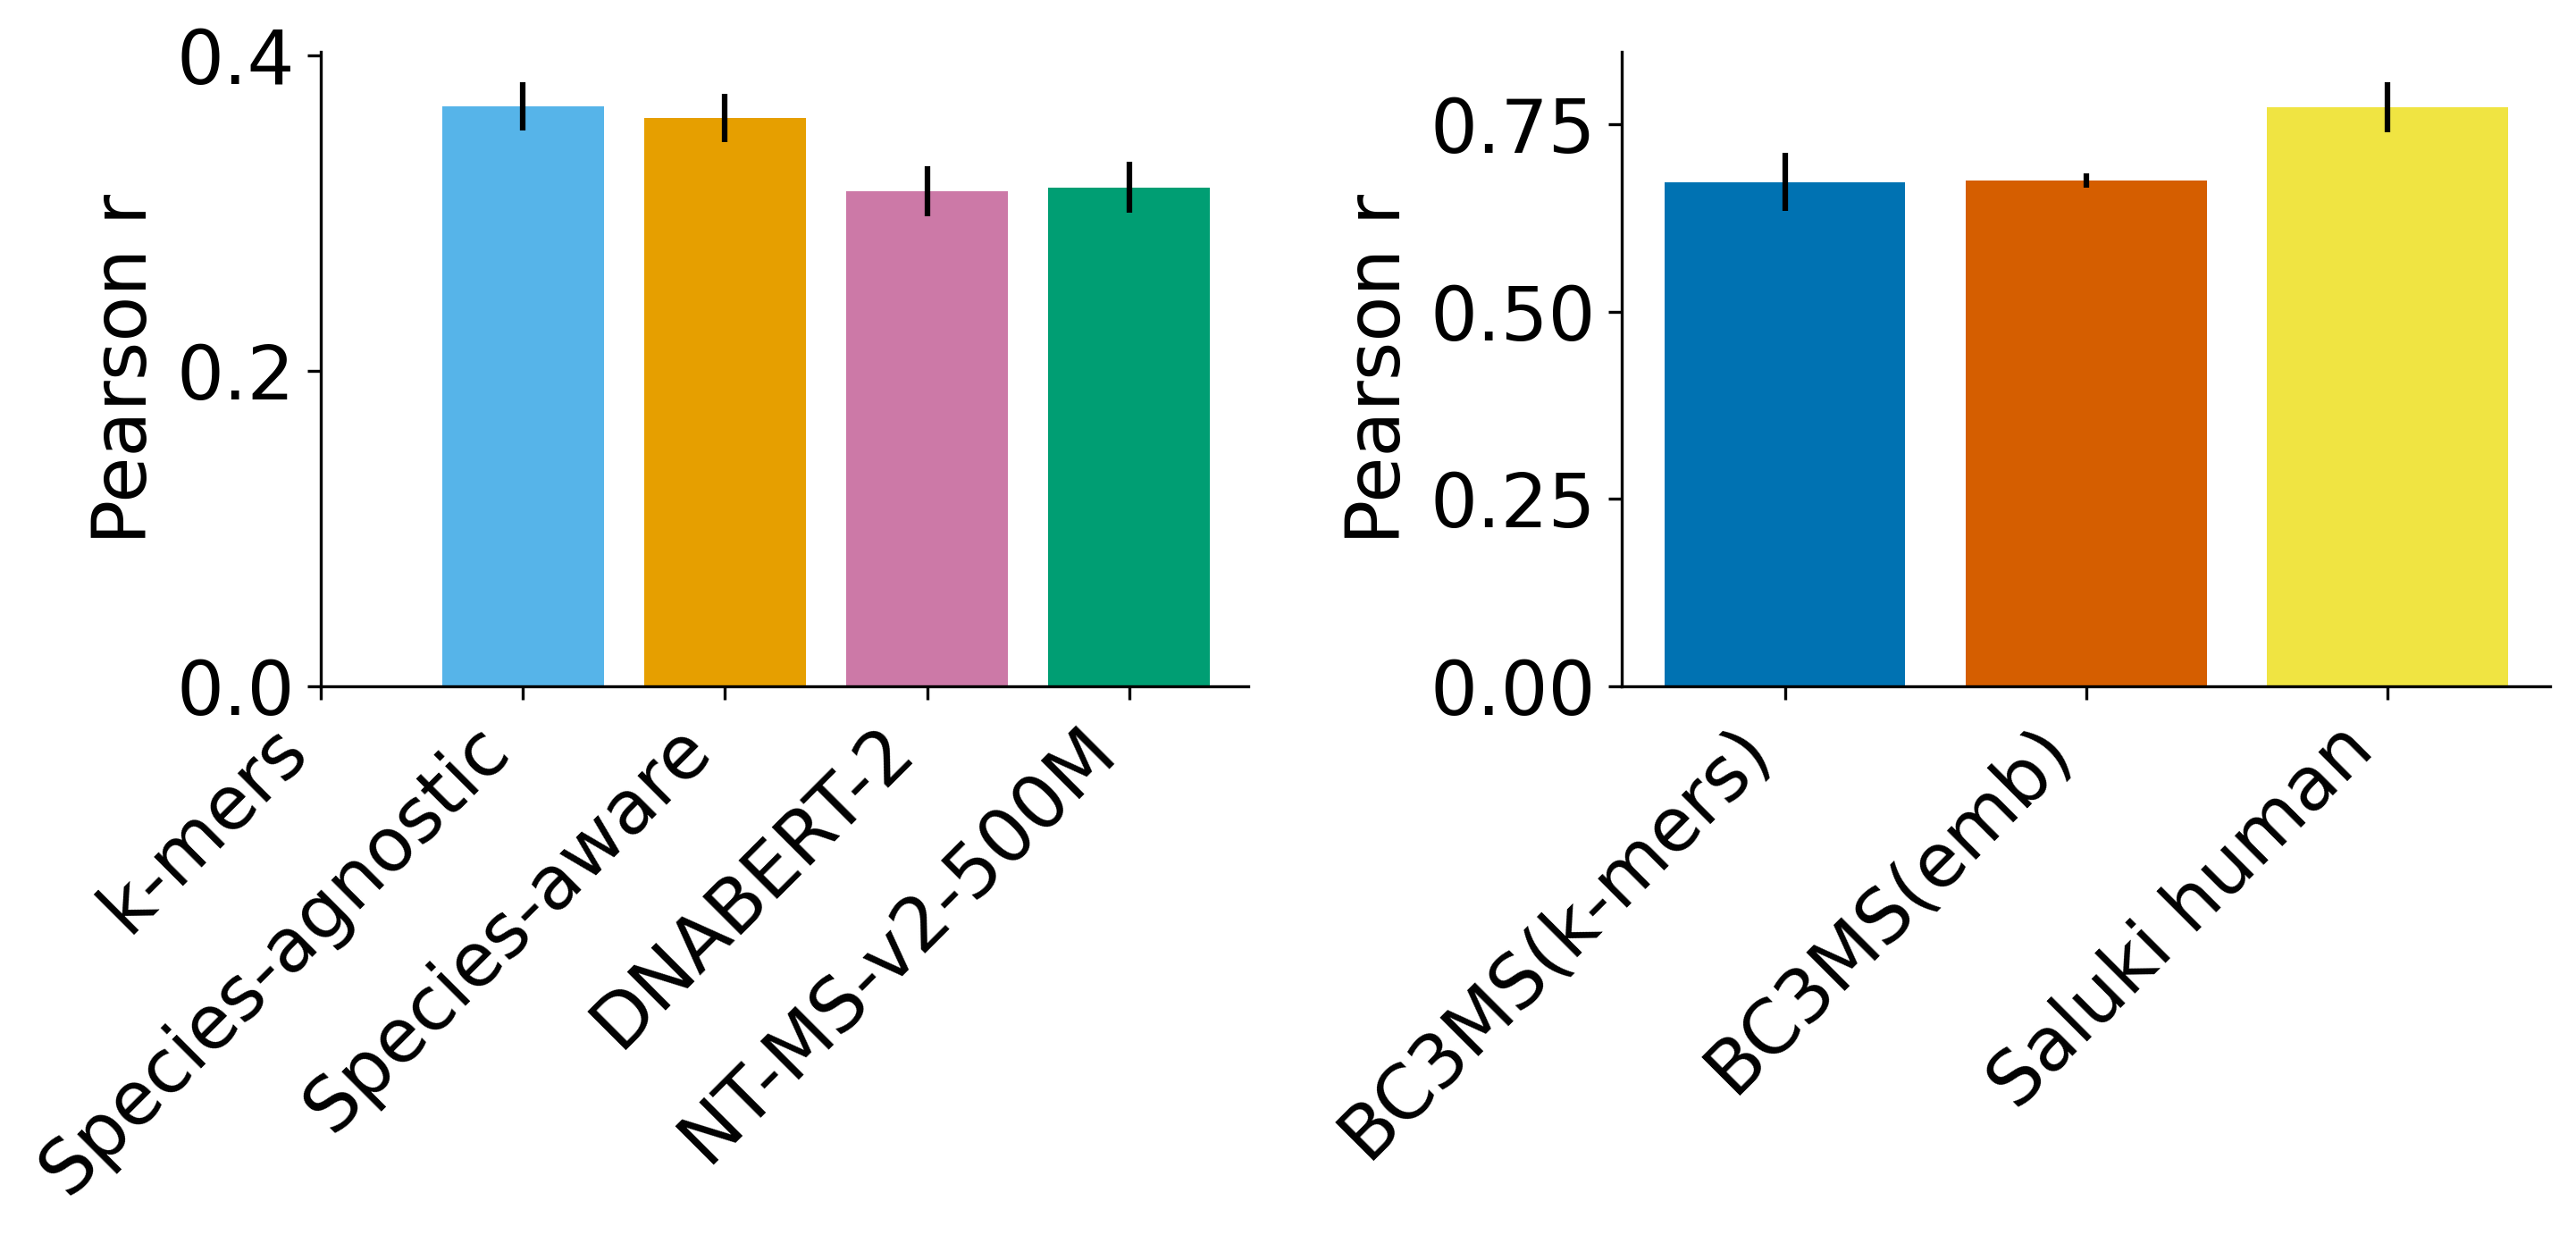

In [7]:
fig, axes = plt.subplots(1,2,dpi=300, figsize=(10,5))

df = res_df.loc[['k-mers','Species-agnostic','Species-aware', 'DNABERT-2','NT-MS-v2-500M']]

ax = axes[0]

ax.bar(df.index, df.Pearson_r, yerr=df.CI_95, color=df.index.map(model_colors))
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(),rotation=45, ha="right")
ax.set_ylabel('Pearson r')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

df = res_df.loc[['BC3MS(k-mers)', 'BC3MS(emb)','Saluki human']]

ax = axes[1]

ax.bar(df.index, df.Pearson_r, yerr=df.CI_95, color=df.index.map(model_colors))
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(),rotation=45, ha="right")
ax.set_ylabel('Pearson r')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()